In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import pymupdf
import uuid
from pprint import pprint
from tqdm.notebook import tqdm
from langchain.text_splitter import RecursiveCharacterTextSplitter
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder
from src.evaluation.distance_based import DistanceEvaluator
from src.preprocessing.preprocess import remove_stopwords, clean_text
from src.evaluation.reporting import Reporting
import seaborn as sns

In [2]:
df = pd.read_excel('data/latest.xlsx')

In [3]:
reporting = Reporting(data=df)
sim_matrix = reporting.create_similarity_matrix_for_wmd(on_column='generated_questions_array')

753it [07:38,  1.64it/s]


In [4]:
sim_matrix.shape

(752, 752)

In [5]:
if sim_matrix.shape[0] < 30: #plot only when sampled
    mask = np.zeros_like(sim_matrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(sim_matrix,
                annot=True,
                fmt='.2f',
                linewidth=.5,
                cmap='crest',
                mask=mask,
                annot_kws={'fontsize': 8})

### Evaluation Summary

#### Coverage summary

In [6]:
df['coverage_rating'].value_counts(normalize=True)

coverage_rating
5    1.0
Name: proportion, dtype: float64

<Axes: >

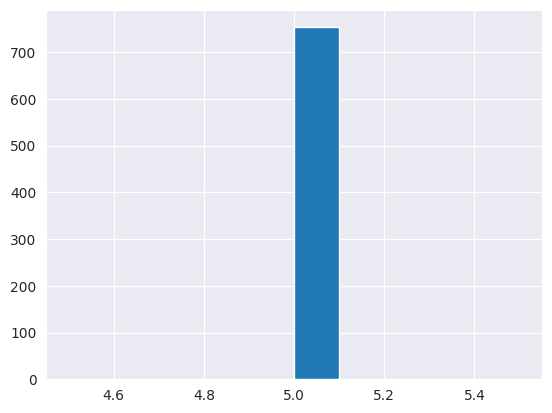

In [7]:
pd.plotting.hist_series(df['coverage_rating'])

In [8]:
df['coverage_rating_no_answer'].value_counts(normalize=True)

coverage_rating_no_answer
5    0.938911
4    0.049137
1    0.007968
2    0.002656
3    0.001328
Name: proportion, dtype: float64

<Axes: >

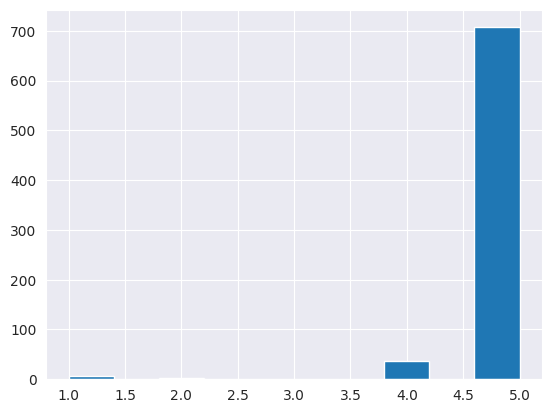

In [9]:
pd.plotting.hist_series(df['coverage_rating_no_answer'])

#### Word mover distance

<Axes: >

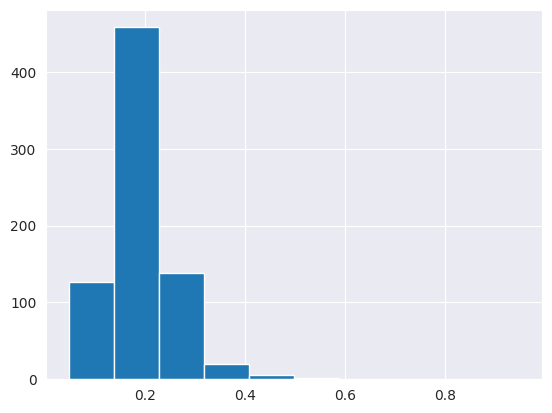

In [10]:
# WMD question <-> chunk
pd.plotting.hist_series(df['wmd'])

In [11]:
mean_wmd_qch = df['wmd'].mean()
std_wmd_qch = df['wmd'].std()
print(f'Mean for question to chunk for WMD is {mean_wmd_qch} with std as {std_wmd_qch}')

Mean for question to chunk for WMD is 0.19339181580439138 with std as 0.07003015277804153


<Axes: >

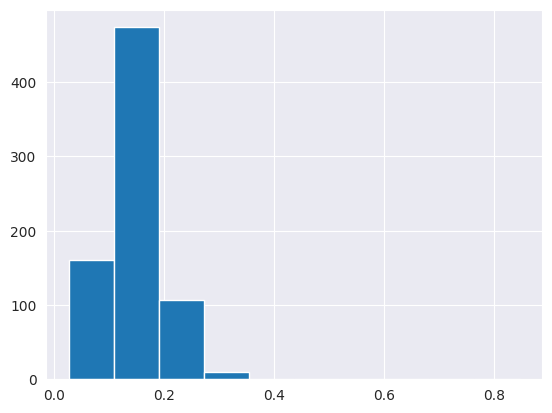

In [12]:
# WMD question <-> answer
pd.plotting.hist_series(df['wmd_question_answer'])

In [13]:
mean_wmd_qa = df['wmd_question_answer'].mean()
std_wmd_qa = df['wmd_question_answer'].std()
print(f'Mean for question to answer for WMD is {mean_wmd_qa} with std as {std_wmd_qa}')

Mean for question to answer for WMD is 0.14663981538771198 with std as 0.05362387325462629


In [14]:
# WMD question <-> question
std, mean = reporting.get_summary_for_wmd(sim_matrix)
print(f'Mean for question to question for WMD is {mean} with std as {std}')

Mean for question to question for WMD is 0.2407836529716644 with std as 0.06884521720370682


#### Coherence rate

In [15]:
df['coherence_rate'].value_counts(normalize=True)

coherence_rate
4                                                                                                                                                                                                                               0.435591
3                                                                                                                                                                                                                               0.430279
2                                                                                                                                                                                                                               0.124834
3 | The question is coherent in terms of addressing legal consequences of non-compliance with regulations related to the provision of medicinal products and medical devices in the context of healthcare services. However     0.001328
3 | The question is coherent in terms of addressing t


#### Evaluation Summary
From the provided results we can observe that in majority of cases generated question are quite fluent (86.5% got score 3 and 4 combined).
Coverage metric (if answer can be reliable extracted from question and context) is also high. This point is to be investigated as it was based on LLM verification.
Word's Mover Distance (Diversity) with mean scores 0.19, 0.14 and 0.24 for question to chunk, question to answer and question to question respectively, show that generated questions have small distance which means that they show small diversity and are consistent with each other. 